In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow_hub
# !pip install tensorflow_text

In [ ]:
# pip install tensorflow==2.15.*
# !pip install -U "tensorflow-text==2.15.*"
# !pip install -U "tf-models-official==2.15.*"

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

import pandas as pd
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize
import string, re, nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name="BERT_encoder")

**Example Usage - BERT Processor and Encoder**

In [ ]:
text_test = ['nice movie indeed', 'I hate it sometimes though!!']
preprocessed_text = preprocessor(text_test)
print(preprocessed_text.keys())

output = encoder(preprocessed_text)
output.keys()

dict_keys(['input_mask', 'input_word_ids', 'input_type_ids'])


dict_keys(['encoder_outputs', 'pooled_output', 'default', 'sequence_output'])

In [ ]:
output['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.791774  , -0.21411912,  0.49769545, ...,  0.24465235,
        -0.47334474,  0.8175869 ],
       [-0.7811995 , -0.40898427, -0.48670244, ..., -0.21824645,
        -0.62682813,  0.8872608 ]], dtype=float32)>

**Reading the Saved CSV**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mentalhealth_comments.csv')

In [ ]:
df = df[['comment_id', 'comment_body']]
df.sample(10)

,comment_id,comment_body
2430,kf6le75,I love a ribeye!\n\nThe rest of your comment h...
2757,kf5t68o,Good discussion point. Don't agree with all bu...
359,kf711qd,Dont avoid fat and sugar avoid getting fat wit...
1944,kf8tld1,What is wrong with porn?
2138,kf5kxz0,So we've always had these to some extent. I di...
2978,kf683kn,"""Avoid caffeine"" NO."
181,kf6vn7b,"Look, jokes aside I cannot understate how all ..."
926,kfap927,Sometimes you do everything right and it’s sti...
1909,kf5wt91,Agreed. So much of this stuff is 'what works f...
578,kfekwix,My wife is one of these people and to be hones...


In [ ]:
train_df = df.iloc[:2000, :]
test_df = df.iloc[train_df.shape[0]: , :]

In [ ]:
train_df.shape, test_df.shape, len(train_df + test_df)

((2000, 2), (995, 2), 2995)

**First I've defined sentiments for each thread using SentimentVader**

In [ ]:
def preprocess_text(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

train_df['cleaned_comment_text'] = train_df['comment_body'].apply(preprocess_text)
test_df['cleaned_comment_text'] = test_df['comment_body'].apply(preprocess_text)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

vader_analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer(text):
    scores = vader_analyzer.polarity_scores(text)
    compound_score = scores['compound']
    return 'positive' if compound_score >= 0 else 'negative'

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
train_df['sentiment'] = train_df['cleaned_comment_text'].apply(sentiment_analyzer)
test_df['sentiment'] = test_df['cleaned_comment_text'].apply(sentiment_analyzer)

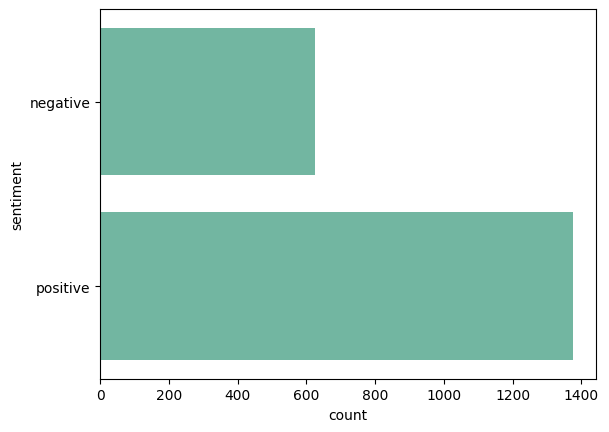

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('Set2')
sns.countplot(train_df['sentiment'])
plt.show()

**To address class imbalance -> Class Weight Method -> Incomplete**

In [ ]:
train_df['label'] = train_df['sentiment'].map({'positive': 1, 'negative': 0})
test_df['label'] = test_df['sentiment'].map({'positive': 1, 'negative': 0})


X_train, X_val, y_train, y_val = train_test_split(
    train_df['comment_body'], train_df['label'], test_size = 0.1, random_state = 43, stratify = train_df['label']
)

**Bert Model**

In [ ]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
encoded_text = encoder(preprocessed_text)['pooled_output']

# NN Layers
# Regularization
l = tf.keras.layers.Dropout(0.1, name = 'DropOut')(encoded_text)
# Fully Connected
l = tf.keras.layers.Dense(1, activation = 'sigmoid' ,name = 'Dense')(l)

model = tf.keras.Model(inputs = [text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = METRICS
)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
57/57 [==============================] - 28s 301ms/step - loss: 0.6356 - accuracy: 0.6694 - precision: 0.6832 - recall: 0.9677
Epoch 2/10
57/57 [==============================] - 19s 336ms/step - loss: 0.6242 - accuracy: 0.6828 - precision: 0.6888 - recall: 0.9822
Epoch 3/10
57/57 [==============================] - 18s 315ms/step - loss: 0.6101 - accuracy: 0.6856 - precision: 0.6916 - recall: 0.9790
Epoch 4/10
57/57 [==============================] - 17s 305ms/step - loss: 0.5821 - accuracy: 0.6989 - precision: 0.6982 - recall: 0.9895
Epoch 5/10
57/57 [==============================] - 17s 305ms/step - loss: 0.5747 - accuracy: 0.7028 - precision: 0.7008 - recall: 0.9903
Epoch 6/10
57/57 [==============================] - 18s 315ms/step - loss: 0.5797 - accuracy: 0.7111 - precision: 0.7187 - recall: 0.9523
Epoch 7/10
57/57 [==============================] - 18s 311ms/step - loss: 0.5630 - accuracy: 0.7194 - precision: 0.7248 - recall: 0.9539
Epoch 8/10
57/57 [================

In [ ]:
model.evaluate(X_val, y_val)

7/7 [==============================] - 3s 266ms/step - loss: 0.5389 - accuracy: 0.6900 - precision: 0.6884 - recall: 1.0000


[0.5389381051063538, 0.6899999976158142, 0.6884422302246094, 1.0]

In [ ]:
y_pred = model.predict(X_val)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

7/7 [==============================] - 3s 290ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

Text(50.722222222222214, 0.5, 'Truth')

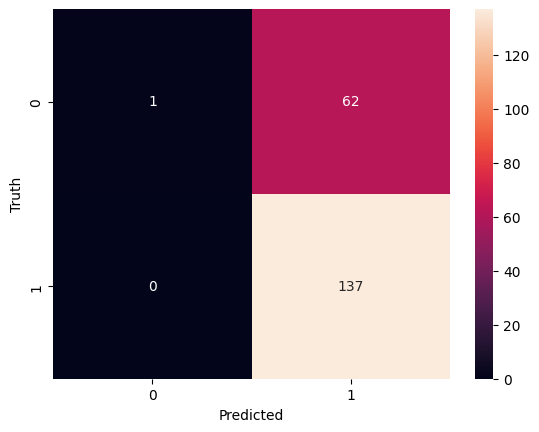

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03        63
           1       0.69      1.00      0.82       137

    accuracy                           0.69       200
   macro avg       0.84      0.51      0.42       200
weighted avg       0.79      0.69      0.57       200



In [ ]:
y_test_pred = model.predict(test_df['comment_body'])
y_test_pred = np.where(y_test_pred > 0.5 , "Positive", "Negative").flatten()
y_test_pred

32/32 [==============================] - 10s 312ms/step


array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Negative', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [ ]:
sub_threads = [
    "I feel empty, nothing makes me happy",
    "Anyone else just soo exhausted from life?",
    "What's something that recently made you happy?",
    "Share your best 'feel-good' story"
]

model.predict(sub_threads)

1/1 [==============================] - 1s 794ms/step


array([[0.64418775],
       [0.82626635],
       [0.73924387],
       [0.832798  ]], dtype=float32)